In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv("2317.csv")
df.isna().sum()
# 算 Pandas Dataframe 列中的 NaN 出現的次數

date                   0
Open                   0
High                   0
Low                    0
Close                  0
Change                 0
Change%                0
Volume('000 shares)    0
dtype: int64

Lstm比RNN多了一個forget gate會到一定時間便丟棄data使得不會梯度爆炸or梯度消失
GRU是把forget gate跟input gate merge->updata gate


In [ ]:
df.drop(['Change'], axis=1, inplace=True) #不需要上期比
df.columns = ['date','Open','High','Low','Close','RD','Volume']
df
#%%
# 將日期設為index
df.set_index(['date'], inplace=True)
df
# inplace=True 覆蓋檔案

,Open,High,Low,Close,RD,Volume
date,,,,,,
2010/1/4,152.0,152.5,150.5,151.5,0.00,23703.729
2010/1/5,153.5,155.5,151.5,152.5,0.66,34765.658
2010/1/6,152.5,153.0,151.5,151.5,-0.66,28645.356
2010/1/7,151.5,152.5,148.5,150.0,-0.99,28165.060
2010/1/8,150.0,151.0,147.0,150.5,0.33,23525.808
...,...,...,...,...,...,...
2020/12/25,90.9,92.2,90.8,91.8,2.46,114607.503
2020/12/28,92.4,93.0,91.8,91.8,0.00,67626.965
2020/12/29,91.8,91.8,90.4,90.4,-1.53,46148.101


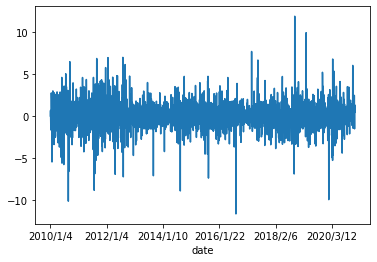

In [ ]:
#應變量
df.RD.plot()

In [ ]:
# 先拆分，再正規化
train = df[0:2670]
test = df[2670:]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# StandardScaler (平均值和標準差)
# 將所有特徵標準化，也就是高斯分佈。使得數據的平均值為0，方差為1。
# 適合的使用時機於當有些特徵的方差過大時，使用標準化能夠有效地讓模型快速收斂。

# MinMaxScaler(最小最大值標準化)
# 是給定了一個明確的最大值與最小值。每個特徵中的最小值變成了0，最大值變成了1。數據會縮放到到[0,1]之間。

# MaxAbsScaler（絕對值最大標準化）
# MaxAbsScaler 與 MinMaxScaler 類似，所有數據都會除以該列絕對值後的最大值。
# 數據會縮放到到[-1,1]之間。

# RobustScaler
# 中位數和四分位數標準化
# 可以有效的縮放帶有outlier的數據，透過Robust如果數據中含有異常值在縮放中會捨去。

train = pd.DataFrame(scaler.fit_transform(train), columns=df.columns)
test = pd.DataFrame(scaler.fit_transform(test), columns=df.columns)
# fit_transform(trainData)對部分數據先擬合fit，找到該part的整體指標，
# 如均值、方差、最大值最小值等等（根據具體轉換的目的），然後對該trainData進行轉換transform，
# 從而實現數據的標準化、歸一化等等。
# fit(): Method calculates the parameters μ and σ and saves them as internal objects.
# 解釋：簡單來說，就是求得訓練集X的均值，方差，最大值，最小值,這些訓練集X固有的屬性。

# transform(): Method using these calculated parameters apply the transformation to a particular dataset.
# 解釋：在fit的基礎上，進行標準化，降維，歸一化等操作（看具體用的是哪個工具，如PCA，StandardScaler等）。

# fit_transform(): joins the fit() and transform() method for transformation of dataset.
# 解釋：fit_transform是fit和transform的組合，既包括了訓練又包含了轉換。

#%
#製造X跟Y(RD)
import tqdm
n = 30 #改n即可，資料1/4起，所以能預測的第一個Y為2/3，抓30天
# 用前30天的資料去預測下一天的值
feature_names = list(train.drop('RD', axis=1).columns)
X = []
y = []
indexes = []
norm_data_x = train[feature_names]
for i in tqdm.tqdm_notebook(range(0,len(train)-n)): 
  X.append(norm_data_x.iloc[i:i+n]. values) 
  y.append(train['RD'].iloc[i+n-1]) #現有資料+30天的Y
  indexes.append(train.index[i+n-1]) #Y的日期

print(X[0])
print(y[0])

X=np.array(X) # RD外的6個自變量，記憶體=30，EX:預測12/31的Y，用12/1~12/30的X
y=np.array(y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2640 [00:00<?, ?it/s]

[[0.98355263 0.96692393 0.98888889 0.98355263 0.05871758]
 [1.         1.         1.         0.99451754 0.09446349]
 [0.98903509 0.9724366  1.         0.98355263 0.07468613]
 [0.97807018 0.96692393 0.96666667 0.96710526 0.07313408]
 [0.96162281 0.95038589 0.95       0.97258772 0.05814264]
 [0.93969298 0.93936053 0.96111111 0.95065789 0.05992643]
 [0.94517544 0.93384785 0.95555556 0.94517544 0.09208077]
 [0.91776316 0.90628445 0.92777778 0.91776316 0.08557285]
 [0.91776316 0.93936053 0.93888889 0.96162281 0.05890474]
 [0.97807018 0.9724366  0.98333333 0.99451754 0.07512939]
 [0.97258772 0.96141125 0.98333333 0.97807018 0.03246007]
 [0.97807018 0.96141125 0.96111111 0.95614035 0.04083532]
 [0.96162281 0.93936053 0.95       0.93969298 0.07117562]
 [0.9122807  0.90628445 0.92777778 0.92324561 0.0704968 ]
 [0.8629386  0.85115766 0.83888889 0.83552632 0.22169568]
 [0.80811404 0.82910695 0.82222222 0.85197368 0.09297896]
 [0.8629386  0.8401323  0.82222222 0.81907895 0.10736995]
 [0.81907895 0

In [ ]:
# Adding the LSTM layer
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
n_steps = 30 
# 往回看30天

n_features = 5
# 參考五個特徵

model = Sequential()
model.add(LSTM(50,activation='relu', return_sequences=False, input_shape = (n_steps, n_features)))
# 50->神經元數目
#input_shape = (n_steps, n_features)  幾步, 幾個特徵
# return_sequences預設false，輸出是否為序列? 是: 預測多個值 這裡只預測rd

model.add(Dense(1))
# 預測一個值

model.compile(optimizer = 'adam', loss = 'mse' , metrics=['mse','mape'])

Epoch 1/200
27/27 [==============================] - 4s 24ms/step - loss: 0.0958 - mse: 0.0958 - mape: 113630.7969
Epoch 2/200
27/27 [==============================] - 1s 19ms/step - loss: 0.0127 - mse: 0.0127 - mape: 196436.3906
Epoch 3/200
27/27 [==============================] - 1s 19ms/step - loss: 0.0062 - mse: 0.0062 - mape: 196939.7656
Epoch 4/200
27/27 [==============================] - 1s 19ms/step - loss: 0.0057 - mse: 0.0057 - mape: 197798.2031
Epoch 5/200
27/27 [==============================] - 1s 19ms/step - loss: 0.0054 - mse: 0.0054 - mape: 199315.3281
Epoch 6/200
27/27 [==============================] - 1s 20ms/step - loss: 0.0053 - mse: 0.0053 - mape: 191706.9531
Epoch 7/200
27/27 [==============================] - 1s 19ms/step - loss: 0.0052 - mse: 0.0052 - mape: 190208.1719
Epoch 8/200
27/27 [==============================] - 1s 20ms/step - loss: 0.0051 - mse: 0.0051 - mape: 191806.3906
Epoch 9/200
27/27 [==============================] - 1s 19ms/step - loss: 0.0050

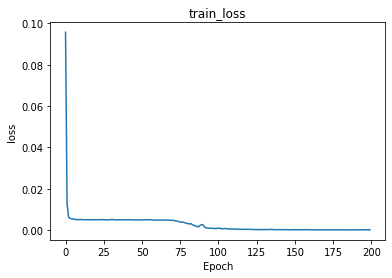

In [ ]:
history = model.fit(X,y,batch_size=100,epochs=200)

# 顯示loss
import matplotlib.pyplot as plt

plt.title('train_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.plot(history.history["loss"])
#%%


In [ ]:
#製造X跟Y(RD)
import tqdm
n = 30 #改n即可，資料1/4起，所以能預測的第一個Y為2/3，抓30天
feature_names = list(test.drop('RD', axis=1).columns)
X = []
y = []
indexes = []
norm_data_x = test[feature_names]
for i in tqdm.tqdm_notebook(range(0,len(test)-n)): 
  X.append(norm_data_x.iloc[i:i+n].values)  
  y.append(test['RD'].iloc[i+n-1]) #現有資料+30天的Y 實際值
  indexes.append(test.index[i+n-1]) #Y的日期
X=np.array(X) # RD外的6個自變量，記憶體=30，EX:預測12/31的Y，用12/1~12/30的X
y=np.array(y)

predictions = model.predict(X)
predictions = pd.DataFrame(predictions).rename(columns={0: '預測值'})
Y_test = pd.DataFrame(y).rename(columns={0: '實際值'})

final = pd.concat([predictions,Y_test],axis=1)
final['mae'] = abs(final['預測值'] - final['實際值'])
final

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/3 [00:00<?, ?it/s]

,預測值,實際值,mae
0,0.507399,0.202381,0.305018
1,0.151832,0.000000,0.151832
2,0.733496,0.378307,0.355190


In [ ]:
norm_data = pd.DataFrame(scaler.inverse_transform(norm_data), columns=df.columns, index=df.index)

NameError: ignored

In [ ]:
X.size

450

In [ ]:
len(test)

33

In [ ]:

#norm_data = pd.DataFrame(scaler.inverse_transform(norm_data), columns=df.columns, index=df.index)

NameError: ignored